In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, average_precision_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

def performance_result(y_true, y_pred):
    confusion_matrix_plot(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print('FP rate=FP/(FP+TN): ',"{:.4f}".format(fp/((fp+tn))))
    print('Precision=TP/(TP+FP) : ', "{:.4f}".format(precision_score(y_true, y_pred)))
    print('Recall=TP/(TP+FN) : ', "{:.4f}".format(recall_score(y_true, y_pred)))
    print('AUC-PR: ', "{:.4f}".format(average_precision_score(y_true, y_pred)))
    print('f1-score: ', "{:.4f}".format(f1_score(y_true, y_pred)))
    print('roc_auc: ', "{:.4f}".format(roc_auc_score(y_true, y_pred)))
    print('Accuracy: ', "{:.4f}".format(accuracy_score(y_true, y_pred)))
   
def confusion_matrix_plot(y_true, y_pred):
    plt.rcParams['font.size'] = '12'
    fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_true, y_pred), 
                                    show_absolute=True,
                                    show_normed=True,
                                    figsize=(4, 4))


    fig.suptitle('Confusion Matrix', fontsize=16)
    plt.show()
class column_search():
    def __init__(self,df):
        self.cols=pd.Series(df.columns)
    def search(self,astr):
        return(list(self.cols[self.cols.str.contains(astr)]))
    
def surv_rate(col_name):
    out=df.groupby(col_name).agg({'target':[av,len]}).reset_index()
    out.columns=['val,surv,num'.split(',')]
    return(out)
def drate_plot(col_name):
    srates=surv_rate(col_name)
    ((1-srates.surv)*1000).plot(kind='bar')
    plt.title('Deaths out of 1000 births')
    plt.ylabel('Deaths')
    plt.xlabel(col_name+' val')
    plt.legend().remove()
    plt.show()
def occur_plot(col_name):
    srates=surv_rate(col_name)
    srates.num.plot(kind='bar')
    plt.title('value freq')
    plt.ylabel('freq')
    plt.xlabel(col_name+' val')
    plt.legend().remove()
    plt.show()
    
def tp(col_name):
    srates=surv_rate(col_name)
    
    xlabs=list(srates['val'].values[:,0])

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(col_name)
    ax1.bar(x=xlabs, height=list(((1-srates.surv)*1000).values[:,0]))
    ax2.bar(x=xlabs,height=srates.num.values[:,0])
    ax1.set_title('deaths per 1k births')
    ax2.set_title('distribution')
    plt.show()
pd.set_option('display.max_columns', None)
plt.rcParams['axes.titlesize']=16

###  Data Source: 

https://data.nber.org/nvss/linkco/csv/2015/linkco2015usnum.csv

The Raw Data is too large to upload to github, but can be downloaded from the above link. I have saved the output of the data cleaning process below as a parquet file that will be uploaded to github. 

In [7]:
df=pd.read_csv('linkco2015usnum.csv')
keeper_cols=['dob_mm','dob_wk','dob_tt','bfacil3','mager','mbstate_rec',\
 'mrace6','dmar','meduc','fage11', 'frace6','feduc','riorlive','riordead','riorterm',\
'recare5','revis','cig_0','cig_1','cig_2','cig_3','mhtr','bmi','wgt_r','dwgt_r','wtgain',\
'me_rout','dmeth_rec','mm_aicu','ay','ay_rec','apgar5','dplural','sex','dispo','ucod']

df=df[keeper_cols]
def ucod(x):
    if x == '1.00':
        return(1)
    else:
        return(0)
    
df['survival']=df.ucod.apply(ucod)

df=df.drop(columns='ucod')
df=df.drop(columns='dob_tt')
df=df.drop(columns='me_rout')
df=df.drop(columns='mm_aicu')
df=df.drop(columns='ay')
df=df.drop(columns='dispo')
df=df.drop(columns='dwgt_r')
df=df.drop(columns='fage11')

days={1 : 'Sunday',
2: 'Monday',
3: 'Tuesday',
4: 'Wednesday', 5: 'Thursday',
6: 'Friday',
7: 'Saturday'}

months={1:'January',2: 'February',3: 'March',4: 'April',
5:'May',
6:'June',
7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}

df.dob_mm=df.dob_mm.map(months)
df.dob_wk=df.dob_wk.map(days)

df['bfacil3']=df.bfacil3.map({1:"Hospital",2:"Not_Hospital",3:"Unknown"})
df['mbstate_rec']=df.mbstate_rec.map({1:"USA",2:"Not_USA",3:"Unknown"})
df.mrace6=df.mrace6.map({1:"White",2:"Black",3:"AIAN",4:"Asian",5:"NHOPI",6:"Mixed_Race",9:None})
df.dmar=df.dmar.map({1:"Married",2:"Unmarried"})
df.frace6=df.frace6.map({1:"White",2:"Black",3:"AIAN",4:"Asian",5:"NHOPI",6:"Mixed_Race",9:None})

educ={1: '<8th',
 2: '9th-12th_NO_DIP',
 3: 'High_School',
 4: 'some_college',
 5: 'Associates',
 6: 'Bachelors',
 7: 'Masters',
 8: 'Doctorate',
 9: 'Unknown',
 0: "Missing_value"}

df.feduc=df.feduc.map(educ)
df.meduc=df.meduc.map(educ)

for col in ['riorlive', 'riordead', 'riorterm']:
    df[col]=df[col].replace(99,None)

prenatal_start={1: '1st to 3rd month',
2:'4th to 6th month',
3: '7th to final month',
4: 'No prenatal care',
5: 'Unknown or not stated',
0: None}

df.recare5=df.recare5.map(prenatal_start)

av_prenatal_visit_count=df[df.revis<99].revis.mean()

df.revis=df.revis.replace(99,av_prenatal_visit_count)

cigs=['cig_0',
 'cig_1',
 'cig_2',
 'cig_3',]
for x in cigs:
    df[x]=df[x].replace(99,None)
    
df.mhtr=df.mhtr.replace(99,None)
    

bmi_mode=df.bmi.mode()  
df.bmi=df.bmi.replace(99.9,None)
df.bmi=df.bmi.fillna(bmi_mode)
bmi_mode=df[(df.bmi>1)].bmi.mode()


df.wgt_r=df.wgt_r.replace(0,None).replace(999,None)
av_wgt=df.wgt_r.mean()
df.wgt_r=df.wgt_r.fillna(av_wgt)

av_wtgain=df[df.wtgain!=99].wtgain.mean()
df.wtgain=df.wtgain.replace(99,av_wtgain)

df.dmeth_rec=df.dmeth_rec.map({1:"traditional",2:"non_traditional",9:"non_traditional"})

df.ay_rec=df.ay_rec.map({0:None,1:"Medicaid",2:"Private_Insurance",3:'Self-Pay',4:'Other',9:"Unknown"})

df['apgar5']=df.apgar5.replace(99,None)




catcols=list(df.columns)
numcols=['mager','riorlive',
 'riordead',
 'riorterm','revis','cig_0',
 'cig_1',
 'cig_2',
 'cig_3',
 'mhtr',
 'bmi',
 'wgt_r',
 'wtgain','apgar5','dplural','survival']
for col in numcols:
    catcols.remove(col)
    df[col]=pd.to_numeric(df[col])
    

df.ay_rec=df.ay_rec.fillna('Unknown')
df.apgar5=df.apgar5.fillna(df.apgar5.mean())
df.mrace6=df.mrace6.fillna('Not_Specified')
df.frace6=df.frace6.fillna('Not_Specified')
for x in ['riorlive','riordead','riorterm','cig_0','cig_1','cig_2','cig_3','mhtr','bmi']:
    df[x]=df[x].fillna(df[x].mean())

df.recare5=df.recare5.fillna('Unknown or not stated')

column_dict={'num':['mager',
 'riorlive',
 'riordead',
 'riorterm',
 'revis',
 'cig_0',
 'cig_1',
 'cig_2',
 'cig_3',
 'mhtr',
 'bmi',
 'wgt_r',
 'wtgain',
 'apgar5',
 'dplural'], 'cat':['dob_mm',
 'dob_wk',
 'bfacil3',
 'mbstate_rec',
 'mrace6',
 'dmar',
 'meduc',
 'frace6',
 'feduc',
 'recare5',
 'dmeth_rec',
 'ay_rec',
 'sex'],'target':['survival']}

df.to_parquet('cleaned_births.parquet')

In [23]:
df=pd.read_parquet('cleaned_births.parquet')



### An examination of the numerical features:

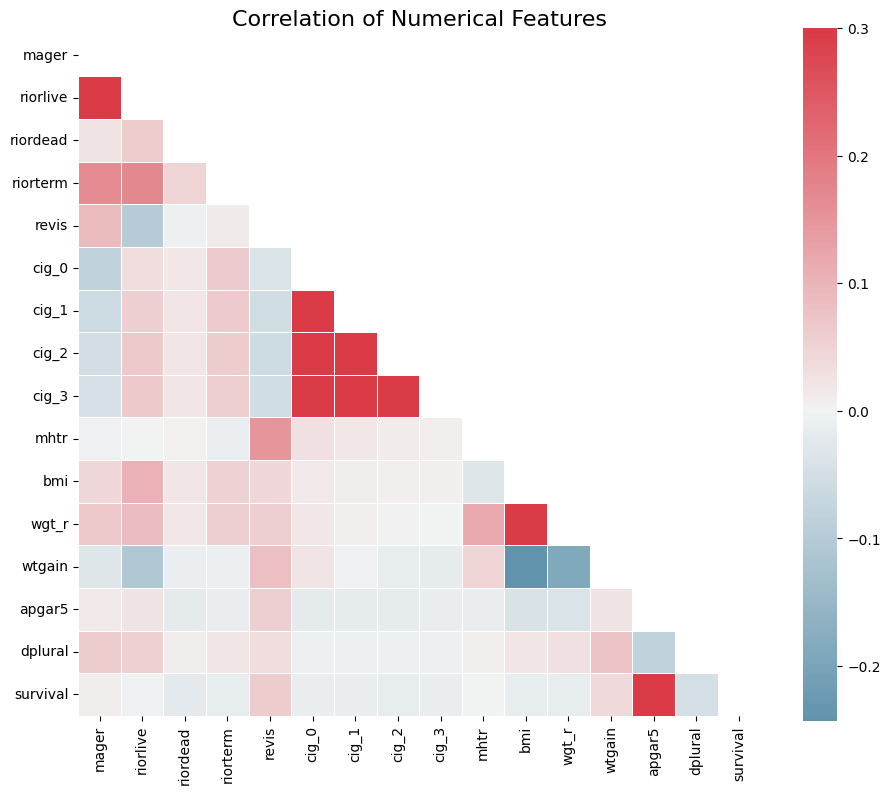

In [29]:
corr = df.select_dtypes(include=np.number).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5)
plt.title('Correlation of Numerical Features')
plt.show()



In [19]:

rus = RandomUnderSampler(random_state=42)


xbal, ybal = rus.fit_resample(df.drop(['survival'],axis=1), df.survival)

xtrain, xtest, ytrain, ytest = train_test_split\
(xbal, ybal, test_size=0.2, random_state=42)

In [136]:
class wrapper():
    
    def __init__(self,classifier):
        self.num=['mager','riorlive','riordead','riorterm','revis', 'cig_0','cig_1','cig_2','cig_3','mhtr','bmi',
 'wgt_r','wtgain','apgar5','dplural']
        self.cat=['dob_mm','dob_wk','bfacil3','mbstate_rec','mrace6','dmar','meduc','frace6','feduc','recare5','dmeth_rec',
 'ay_rec','sex']
        self.target=['survival']
        self.num_scaler=StandardScaler()
        self.cat_scaler=OneHotEncoder()
        self.col_transform = ColumnTransformer([('num',self.num_scaler,self.num),
                               ('cat',self.cat_scaler, self.cat)])
        self.classifier=classifier
        self.pipe = Pipeline(steps=[('col_transform', self.col_transform),
                      ('classifier', self.classifier)])
    def fit(self,X,Y):
        self.pipe.fit(X,Y)
        #self
        return(self)
    def predict(self,xtesta):
        return(self.pipe.predict(xtesta))

    def set_colscaler(self,new_scaler):
        self.new_scaler=new_scaler
    def performance(self,xtst,ytst):
        performance_result(ytst,self.pipe.predict(xtst))
    

### GridSearchCV

With the data set up for experimentation and some a helpful class defined, we start by looking at one of the more simple possible models, Logistic Regression. 

To find the best hyperparameter for said Logistic Regression we can use GridSearchCV seen below to find an ideal regularization constant "C"

In [25]:
w=wrapper(LogisticRegression(max_iter=1000))
scaledlr=w.pipe
pgrid={'classifier__C':[0.001,0.01,0.1,1,5,10,50,100]}
lrgs=GridSearchCV(scaledlr,param_grid=pgrid)
lrgs.fit(xtrain,ytrain)

GridSearchCV(estimator=Pipeline(steps=[('col_transform',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['mager',
                                                                          'riorlive',
                                                                          'riordead',
                                                                          'riorterm',
                                                                          'revis',
                                                                          'cig_0',
                                                                          'cig_1',
                                                                          'cig_2',
                                                                          'cig_3',
                                                                          'mhtr',
                                                                          'bmi',
                                                                          'wgt_r',
                                                                          'wtgain',
                                                                          'apgar5',
                                                                          'dplural']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['dob_mm',
                                                                          'dob_wk',
                                                                          'bfacil3',
                                                                          'mbstate_rec',
                                                                          'mrace6',
                                                                          'dmar',
                                                                          'meduc',
                                                                          'frace6',
                                                                          'feduc',
                                                                          'recare5',
                                                                          'dmeth_rec',
                                                                          'ay_rec',
                                                                          'sex'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 5, 10, 50,
                                           100]})

In [35]:
lrgs.best_estimator_.named_steps['classifier']

LogisticRegression(C=5, max_iter=1000)

### GridSearch, Again
For the sake of demonstration we can do this same process again now that we know an ideal value for C is around 5. This same process is repeated below for a set of 20 numbers closer in value to 5:

In [31]:
w=wrapper(LogisticRegression(max_iter=1000))
scaledlr=w.pipe
pgrid={'classifier__C':np.linspace(0.1,10,20)}
lrgs2=GridSearchCV(scaledlr,param_grid=pgrid)
lrgs2.fit(xtrain,ytrain)

GridSearchCV(estimator=Pipeline(steps=[('col_transform',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['mager',
                                                                          'riorlive',
                                                                          'riordead',
                                                                          'riorterm',
                                                                          'revis',
                                                                          'cig_0',
                                                                          'cig_1',
                                                                          'cig_2',
                                                                          'cig_3',
                                                                          'mhtr',
                                                                          'bmi',
                                                                          'wgt_r',
                                                                          'wtgain',
                                                                          'apgar5',
                                                                          'dplural']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['dob_mm',
                                                                          'dob_wk',
                                                                          'bfacil3',
                                                                          'mbstate_rec',
                                                                          'mrace6',
                                                                          'dmar',
                                                                          'meduc',
                                                                          'frace6',
                                                                          'feduc',
                                                                          'recare5',
                                                                          'dmeth_rec',
                                                                          'ay_rec',
                                                                          'sex'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'classifier__C': array([ 0.1       ,  0.62105263,  1.14210526,  1.66315789,  2.18421053,
        2.70526316,  3.22631579,  3.74736842,  4.26842105,  4.78947368,
        5.31052632,  5.83157895,  6.35263158,  6.87368421,  7.39473684,
        7.91578947,  8.43684211,  8.95789474,  9.47894737, 10.        ])})

In [37]:
best_clf=lrgs2.best_estimator_.named_steps['classifier']
best_clf

LogisticRegression(C=0.6210526315789474, max_iter=1000)

### Feature importance

It would now be usefull to know which features are the most usefull for predicting the value of our target variable. This is done below

In [64]:
lrcoefs=best_clf.coef_[0]
lrcoefs

array([ 0.11135372, -0.11976013, -0.12735287, -0.04901055,  0.35327163,
       -0.10676857,  0.03300048, -0.06823823, -0.04859378, -0.10540325,
       -0.03654457,  0.02484977,  0.22305407,  2.5996603 , -0.29589875,
        0.01283973,  0.02892848,  0.00663454,  0.0692061 , -0.06970056,
        0.03862491, -0.07805316, -0.02635685, -0.00829264, -0.04872705,
       -0.03289356,  0.11211055, -0.0196718 , -0.00515496,  0.03147373,
       -0.02288678,  0.05240722, -0.00669344, -0.02515346,  0.33182443,
       -0.16568595, -0.16181798,  0.28234461, -0.12315026, -0.15487385,
        0.03882303, -0.09068908,  0.005807  , -0.05348517,  0.25190483,
       -0.37881679,  0.23077667,  0.08151045, -0.07718996, -0.21570335,
       -0.03661979,  0.17574342,  0.07644187,  0.21618494, -0.12045829,
        0.09375091,  0.13012347, -0.34635804,  0.03121536, -0.03800533,
        0.08999256, -0.09729546, -0.00909255,  0.00577942,  0.04766546,
        0.0052764 , -0.16047806,  0.09204853,  0.04339533,  0.11

In [57]:
tf=lrgs2.best_estimator_.named_steps['col_transform']

In [65]:

lrfeats=tf.get_feature_names_out()
lrfeats

array(['num__mager', 'num__riorlive', 'num__riordead', 'num__riorterm',
       'num__revis', 'num__cig_0', 'num__cig_1', 'num__cig_2',
       'num__cig_3', 'num__mhtr', 'num__bmi', 'num__wgt_r', 'num__wtgain',
       'num__apgar5', 'num__dplural', 'cat__dob_mm_April',
       'cat__dob_mm_August', 'cat__dob_mm_December',
       'cat__dob_mm_February', 'cat__dob_mm_January', 'cat__dob_mm_July',
       'cat__dob_mm_June', 'cat__dob_mm_March', 'cat__dob_mm_May',
       'cat__dob_mm_November', 'cat__dob_mm_October',
       'cat__dob_mm_September', 'cat__dob_wk_Friday',
       'cat__dob_wk_Monday', 'cat__dob_wk_Saturday', 'cat__dob_wk_Sunday',
       'cat__dob_wk_Thursday', 'cat__dob_wk_Tuesday',
       'cat__dob_wk_Wednesday', 'cat__bfacil3_Hospital',
       'cat__bfacil3_Not_Hospital', 'cat__bfacil3_Unknown',
       'cat__mbstate_rec_Not_USA', 'cat__mbstate_rec_USA',
       'cat__mbstate_rec_Unknown', 'cat__mrace6_AIAN',
       'cat__mrace6_Asian', 'cat__mrace6_Black', 'cat__mrace6_Mixed_R

In [69]:
def important_feat(features,coefs):
    frame=pd.DataFrame({'features':features,'utility':coefs})
    frame.utility=frame.utility.apply(np.abs)
    frame=frame.sort_values(by='utility',ascending=False)
    return(frame.reset_index(drop=True))
    

In [72]:
important_feat(lrfeats,lrcoefs)

,features,utility
0,num__apgar5,2.599660
1,cat__recare5_Unknown or not stated,0.532993
2,cat__mrace6_Not_Specified,0.378817
3,cat__feduc_Unknown,0.354548
4,num__revis,0.353272
...,...,...
85,cat__mrace6_Black,0.005807
86,cat__frace6_NHOPI,0.005779
87,cat__frace6_White,0.005276
88,cat__dob_wk_Monday,0.005155


### Examining the results of using Logistic Regression

We now would like to take a look at the actual results of using Logistic Regression with the hyperparameters we found previously. 

In [74]:
log_reg=wrapper(LogisticRegression(C=0.621, max_iter=1000)).fit(xtrain,ytrain)

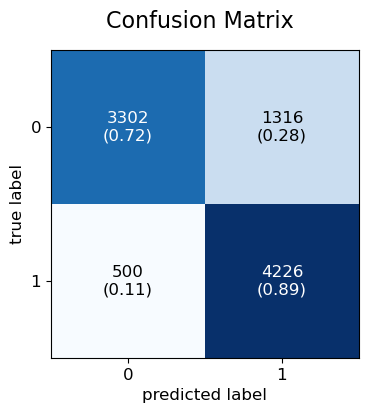

FP rate=FP/(FP+TN):  0.2850
Precision=TP/(TP+FP) :  0.7625
Recall=TP/(TP+FN) :  0.8942
AUC-PR:  0.7354
f1-score:  0.8231
roc_auc:  0.8046
Accuracy:  0.8057


In [76]:
performance_result(ytest,log_reg.predict(xtest))

### Moving on to more complicated models.

With Logistic Regression done we cannow turn our attention to more complicated models. To start we will examine the use of a DecisionTreeClassifier

In [98]:
dtree=wrapper(DecisionTreeClassifier())

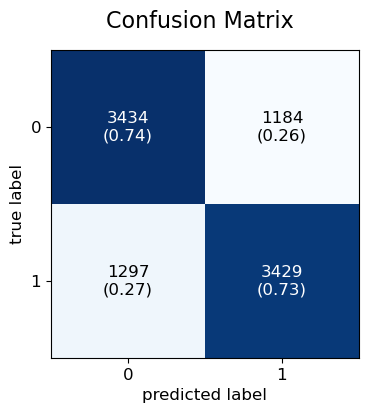

FP rate=FP/(FP+TN):  0.2564
Precision=TP/(TP+FP) :  0.7433
Recall=TP/(TP+FN) :  0.7256
AUC-PR:  0.6781
f1-score:  0.7343
roc_auc:  0.7346
Accuracy:  0.7345


In [100]:
dtree.fit(xtrain,ytrain)
performance_result(ytest,dtree.predict(xtest))

In [105]:
dectree=wrapper(DecisionTreeClassifier()).pipe
pgrid={'classifier__criterion':['gini', 'entropy'],'classifier__max_depth':np.arange(5,100,10)}


In [113]:
gsdt=GridSearchCV(dectree,pgrid,verbose=1)
gsdt.fit(xtrain,ytrain)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(estimator=Pipeline(steps=[('col_transform',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['mager',
                                                                          'riorlive',
                                                                          'riordead',
                                                                          'riorterm',
                                                                          'revis',
                                                                          'cig_0',
                                                                          'cig_1',
                                                                          'cig_2',
                                                                          'cig_3',
                                                                          'mhtr',
                                                                          'bmi',
                                                                          'wgt_r',
                                                                          'wtgain',
                                                                          'apgar5',
                                                                          'dplural']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['dob_mm',
                                                                          'dob_wk',
                                                                          'bfacil3',
                                                                          'mbstate_rec',
                                                                          'mrace6',
                                                                          'dmar',
                                                                          'meduc',
                                                                          'frace6',
                                                                          'feduc',
                                                                          'recare5',
                                                                          'dmeth_rec',
                                                                          'ay_rec',
                                                                          'sex'])])),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': array([ 5, 15, 25, 35, 45, 55, 65, 75, 85, 95])},
             verbose=1)

In [167]:
gsdt.best_estimator_.named_steps['classifier']

DecisionTreeClassifier(max_depth=5)

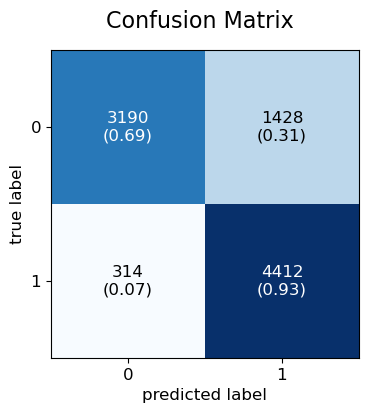

FP rate=FP/(FP+TN):  0.3092
Precision=TP/(TP+FP) :  0.7555
Recall=TP/(TP+FN) :  0.9336
AUC-PR:  0.7389
f1-score:  0.8351
roc_auc:  0.8122
Accuracy:  0.8136


In [112]:
performance_result(ytest,gsdt.best_estimator_.predict(xtest))

### Support Vector Machines

We now implement the SVC class of classifiers

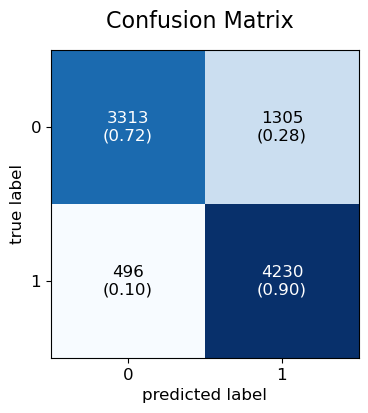

FP rate=FP/(FP+TN):  0.2826
Precision=TP/(TP+FP) :  0.7642
Recall=TP/(TP+FN) :  0.8950
AUC-PR:  0.7371
f1-score:  0.8245
roc_auc:  0.8062
Accuracy:  0.8073


In [127]:
svm=wrapper(SVC())
svm.fit(xtrain,ytrain)
performance_result(ytest,svm.predict(xtest))

In [130]:
svcpipe=wrapper(SVC()).pipe
pgrid_svc={'classifier__kernel':['rbf', 'poly', 'linear', 'sigmoid']}
gssvc=GridSearchCV(svcpipe,pgrid_svc,verbose=3)

In [131]:
gssvc.fit(xtrain,ytrain)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ............classifier__kernel=rbf;, score=0.819 total time= 1.2min
[CV 2/5] END ............classifier__kernel=rbf;, score=0.811 total time= 1.3min
[CV 3/5] END ............classifier__kernel=rbf;, score=0.814 total time= 1.3min
[CV 4/5] END ............classifier__kernel=rbf;, score=0.812 total time= 1.3min
[CV 5/5] END ............classifier__kernel=rbf;, score=0.811 total time= 1.3min
[CV 1/5] END ...........classifier__kernel=poly;, score=0.812 total time= 1.7min
[CV 2/5] END ...........classifier__kernel=poly;, score=0.808 total time= 1.7min
[CV 3/5] END ...........classifier__kernel=poly;, score=0.812 total time= 1.6min
[CV 4/5] END ...........classifier__kernel=poly;, score=0.809 total time= 1.6min
[CV 5/5] END ...........classifier__kernel=poly;, score=0.808 total time= 1.7min
[CV 1/5] END .........classifier__kernel=linear;, score=0.809 total time= 2.5min
[CV 2/5] END .........classifier__kernel=linear;,

GridSearchCV(estimator=Pipeline(steps=[('col_transform',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['mager',
                                                                          'riorlive',
                                                                          'riordead',
                                                                          'riorterm',
                                                                          'revis',
                                                                          'cig_0',
                                                                          'cig_1',
                                                                          'cig_2',
                                                                          'cig_3',
                                                                          'mhtr',
                                                                          'bmi',
                                                                          'wgt_r',
                                                                          'wtgain',
                                                                          'apgar5',
                                                                          'dplural']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['dob_mm',
                                                                          'dob_wk',
                                                                          'bfacil3',
                                                                          'mbstate_rec',
                                                                          'mrace6',
                                                                          'dmar',
                                                                          'meduc',
                                                                          'frace6',
                                                                          'feduc',
                                                                          'recare5',
                                                                          'dmeth_rec',
                                                                          'ay_rec',
                                                                          'sex'])])),
                                       ('classifier', SVC())]),
             param_grid={'classifier__kernel': ['rbf', 'poly', 'linear',
                                                'sigmoid']},
             verbose=3)

In [168]:

gssvc.best_estimator_.named_steps['classifier']

SVC()

### Ensamble techniques

We now proceed to Ensamble techniques in the hopes these will provide a better classification

In [137]:
rfc=wrapper(RandomForestClassifier()).fit(xtrain,ytrain)

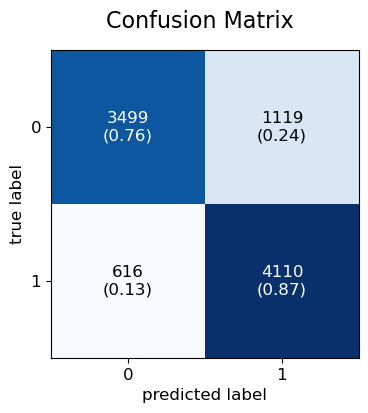

FP rate=FP/(FP+TN):  0.2423
Precision=TP/(TP+FP) :  0.7860
Recall=TP/(TP+FN) :  0.8697
AUC-PR:  0.7495
f1-score:  0.8257
roc_auc:  0.8137
Accuracy:  0.8143


In [138]:
rfc.performance(xtest,ytest)

In [143]:
rfpipe=wrapper(RandomForestClassifier()).pipe
rfpgrid={'classifier__n_estimators':[25,50,75,100,150,200,250]}

rfc_gs=GridSearchCV(rfpipe,rfpgrid,verbose=4)

In [144]:
rfc_gs.fit(xtrain,ytrain)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END .......classifier__n_estimators=25;, score=0.811 total time=   0.8s
[CV 2/5] END .......classifier__n_estimators=25;, score=0.811 total time=   0.8s
[CV 3/5] END .......classifier__n_estimators=25;, score=0.810 total time=   0.8s
[CV 4/5] END .......classifier__n_estimators=25;, score=0.807 total time=   0.8s
[CV 5/5] END .......classifier__n_estimators=25;, score=0.815 total time=   0.8s
[CV 1/5] END .......classifier__n_estimators=50;, score=0.817 total time=   1.6s
[CV 2/5] END .......classifier__n_estimators=50;, score=0.811 total time=   1.6s
[CV 3/5] END .......classifier__n_estimators=50;, score=0.818 total time=   1.6s
[CV 4/5] END .......classifier__n_estimators=50;, score=0.810 total time=   1.6s
[CV 5/5] END .......classifier__n_estimators=50;, score=0.811 total time=   1.6s
[CV 1/5] END .......classifier__n_estimators=75;, score=0.820 total time=   2.3s
[CV 2/5] END .......classifier__n_estimators=75;,

GridSearchCV(estimator=Pipeline(steps=[('col_transform',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['mager',
                                                                          'riorlive',
                                                                          'riordead',
                                                                          'riorterm',
                                                                          'revis',
                                                                          'cig_0',
                                                                          'cig_1',
                                                                          'cig_2',
                                                                          'cig_3',
                                                                          'mhtr',
                                                                          'bmi',
                                                                          'wgt_r',
                                                                          'wtgain',
                                                                          'apgar5',
                                                                          'dplural']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['dob_mm',
                                                                          'dob_wk',
                                                                          'bfacil3',
                                                                          'mbstate_rec',
                                                                          'mrace6',
                                                                          'dmar',
                                                                          'meduc',
                                                                          'frace6',
                                                                          'feduc',
                                                                          'recare5',
                                                                          'dmeth_rec',
                                                                          'ay_rec',
                                                                          'sex'])])),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__n_estimators': [25, 50, 75, 100, 150, 200,
                                                      250]},
             verbose=4)

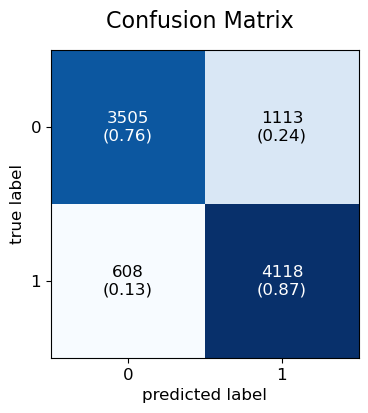

FP rate=FP/(FP+TN):  0.2410
Precision=TP/(TP+FP) :  0.7872
Recall=TP/(TP+FN) :  0.8713
AUC-PR:  0.7510
f1-score:  0.8272
roc_auc:  0.8152
Accuracy:  0.8158


RandomForestClassifier(n_estimators=200)

In [203]:
performance_result(ytest,rfc_gs.best_estimator_.predict(xtest))
rfc_gs.best_estimator_.named_steps['classifier']

In [149]:
rfpipe2=wrapper(RandomForestClassifier(n_estimators=200)).pipe
rfpgrid2={'classifier__max_features':np.arange(10,80,10),
         'classifier__oob_score':[True,False]}
rfc_gs2=GridSearchCV(rfpipe2,rfpgrid2,verbose=4)

In [150]:
rfc_gs2.fit(xtrain,ytrain)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END classifier__max_features=10, classifier__oob_score=True;, score=0.820 total time=   6.8s
[CV 2/5] END classifier__max_features=10, classifier__oob_score=True;, score=0.820 total time=   6.8s
[CV 3/5] END classifier__max_features=10, classifier__oob_score=True;, score=0.820 total time=   6.7s
[CV 4/5] END classifier__max_features=10, classifier__oob_score=True;, score=0.813 total time=   6.8s
[CV 5/5] END classifier__max_features=10, classifier__oob_score=True;, score=0.820 total time=   6.8s
[CV 1/5] END classifier__max_features=10, classifier__oob_score=False;, score=0.821 total time=   6.2s
[CV 2/5] END classifier__max_features=10, classifier__oob_score=False;, score=0.819 total time=   6.2s
[CV 3/5] END classifier__max_features=10, classifier__oob_score=False;, score=0.820 total time=   6.2s
[CV 4/5] END classifier__max_features=10, classifier__oob_score=False;, score=0.816 total time=   6.2s
[CV 5/5] END clas

GridSearchCV(estimator=Pipeline(steps=[('col_transform',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['mager',
                                                                          'riorlive',
                                                                          'riordead',
                                                                          'riorterm',
                                                                          'revis',
                                                                          'cig_0',
                                                                          'cig_1',
                                                                          'cig_2',
                                                                          'cig_3',
                                                                          'mhtr',
                                                                          'bmi',
                                                                          'wgt_r',
                                                                          'wtgain',
                                                                          'apgar5',
                                                                          'dplural']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['dob_mm',
                                                                          'dob_wk',
                                                                          'bfacil3',
                                                                          'mbstate_rec',
                                                                          'mrace6',
                                                                          'dmar',
                                                                          'meduc',
                                                                          'frace6',
                                                                          'feduc',
                                                                          'recare5',
                                                                          'dmeth_rec',
                                                                          'ay_rec',
                                                                          'sex'])])),
                                       ('classifier',
                                        RandomForestClassifier(n_estimators=200))]),
             param_grid={'classifier__max_features': array([10, 20, 30, 40, 50, 60, 70]),
                         'classifier__oob_score': [True, False]},
             verbose=4)

{'classifier__max_features': 20, 'classifier__oob_score': True}


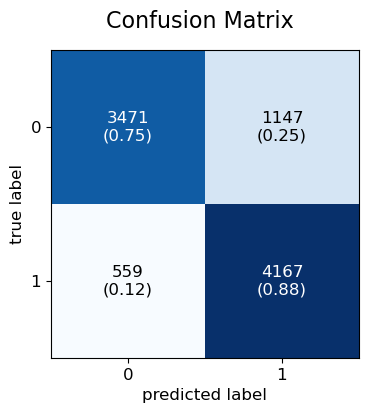

FP rate=FP/(FP+TN):  0.2484
Precision=TP/(TP+FP) :  0.7842
Recall=TP/(TP+FN) :  0.8817
AUC-PR:  0.7512
f1-score:  0.8301
roc_auc:  0.8167
Accuracy:  0.8174


In [153]:
rfc_gs2guess=rfc_gs2.best_estimator_.predict(xtest)
print(rfc_gs2.best_params_)
performance_result(ytest,rfc_gs2guess)


In [169]:
ests=[('lr',wrapper(LogisticRegression(C=0.621, max_iter=1000)).pipe),
      ('dtc',wrapper(DecisionTreeClassifier(max_depth=5)).pipe),
     ('rfc',wrapper(RandomForestClassifier(max_features=20,n_estimators=200)).pipe)]

voter=VotingClassifier(estimators=ests,voting='hard')

In [170]:
voter.fit(xtrain,ytrain)

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('col_transform',
                                               ColumnTransformer(transformers=[('num',
                                                                                StandardScaler(),
                                                                                ['mager',
                                                                                 'riorlive',
                                                                                 'riordead',
                                                                                 'riorterm',
                                                                                 'revis',
                                                                                 'cig_0',
                                                                                 'cig_1',
                                                                                 'cig_2',
                                                                                 'cig_3',
                                                                                 'mhtr',
                                                                                 'bmi',
                                                                                 'wgt_r',
                                                                                 'wtgain',
                                                                                 'apgar5',
                                                                                 'dplural']),
                                                                               ('cat',
                                                                                OneHotEncoder(),
                                                                                ['dob_mm',
                                                                                 'dob_wk',
                                                                                 'bfacil3',
                                                                                 'mbstate_rec',
                                                                                 'mrace6',
                                                                                 'dmar',
                                                                                 'meduc',
                                                                                 'fr...
                                                                                ['mager',
                                                                                 'riorlive',
                                                                                 'riordead',
                                                                                 'riorterm',
                                                                                 'revis',
                                                                                 'cig_0',
                                                                                 'cig_1',
                                                                                 'cig_2',
                                                                                 'cig_3',
                                                                                 'mhtr',
                                                                                 'bmi',
                                                                                 'wgt_r',
                                                                                 'wtgain',
                                                                                 'apgar5',
                                                                                 'dplural']),
                                                                               

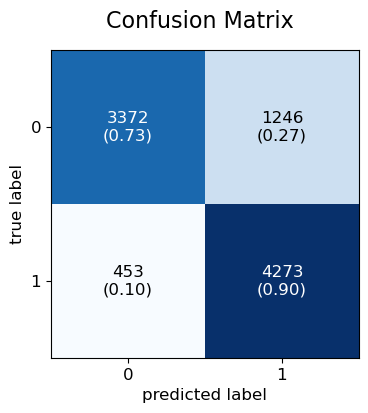

FP rate=FP/(FP+TN):  0.2698
Precision=TP/(TP+FP) :  0.7742
Recall=TP/(TP+FN) :  0.9041
AUC-PR:  0.7485
f1-score:  0.8342
roc_auc:  0.8172
Accuracy:  0.8182


In [172]:
performance_result(ytest,voter.predict(xtest))

### With the above ensemble techniques we have reached a point where Boosting comes into view.

There are a few options in the realm here are a couple: 

In [185]:

ada_param_grid = {
    'classifier__n_estimators': np.arange(25,250,25)}
    
    #'max_depth': [3, 6, 9],
    #'max_leaf_nodes': [3, 6, 9],
#}

In [175]:
adab=wrapper(AdaBoostClassifier()).fit(xtrain,ytrain)

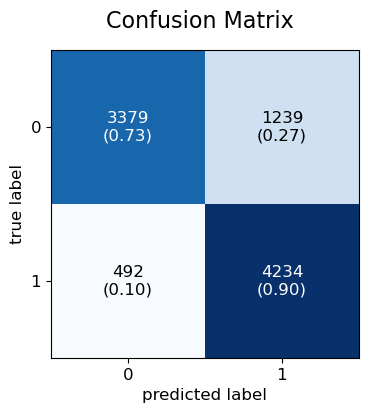

FP rate=FP/(FP+TN):  0.2683
Precision=TP/(TP+FP) :  0.7736
Recall=TP/(TP+FN) :  0.8959
AUC-PR:  0.7457
f1-score:  0.8303
roc_auc:  0.8138
Accuracy:  0.8147


In [176]:
performance_result(ytest,adab.predict(xtest))

In [180]:
adab.classifier.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': 'deprecated',
 'estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [186]:
gsada=GridSearchCV(wrapper(AdaBoostClassifier()).pipe,ada_param_grid,verbose=5)

In [187]:
gsada.fit(xtrain,ytrain)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .......classifier__n_estimators=25;, score=0.816 total time=   0.8s
[CV 2/5] END .......classifier__n_estimators=25;, score=0.817 total time=   0.8s
[CV 3/5] END .......classifier__n_estimators=25;, score=0.820 total time=   0.8s
[CV 4/5] END .......classifier__n_estimators=25;, score=0.812 total time=   0.8s
[CV 5/5] END .......classifier__n_estimators=25;, score=0.816 total time=   0.8s
[CV 1/5] END .......classifier__n_estimators=50;, score=0.821 total time=   1.5s
[CV 2/5] END .......classifier__n_estimators=50;, score=0.819 total time=   1.5s
[CV 3/5] END .......classifier__n_estimators=50;, score=0.823 total time=   1.5s
[CV 4/5] END .......classifier__n_estimators=50;, score=0.816 total time=   1.5s
[CV 5/5] END .......classifier__n_estimators=50;, score=0.819 total time=   1.5s
[CV 1/5] END .......classifier__n_estimators=75;, score=0.819 total time=   2.2s
[CV 2/5] END .......classifier__n_estimators=75;,

GridSearchCV(estimator=Pipeline(steps=[('col_transform',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['mager',
                                                                          'riorlive',
                                                                          'riordead',
                                                                          'riorterm',
                                                                          'revis',
                                                                          'cig_0',
                                                                          'cig_1',
                                                                          'cig_2',
                                                                          'cig_3',
                                                                          'mhtr',
                                                                          'bmi',
                                                                          'wgt_r',
                                                                          'wtgain',
                                                                          'apgar5',
                                                                          'dplural']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['dob_mm',
                                                                          'dob_wk',
                                                                          'bfacil3',
                                                                          'mbstate_rec',
                                                                          'mrace6',
                                                                          'dmar',
                                                                          'meduc',
                                                                          'frace6',
                                                                          'feduc',
                                                                          'recare5',
                                                                          'dmeth_rec',
                                                                          'ay_rec',
                                                                          'sex'])])),
                                       ('classifier', AdaBoostClassifier())]),
             param_grid={'classifier__n_estimators': array([ 25,  50,  75, 100, 125, 150, 175, 200, 225])},
             verbose=5)

In [188]:
gsada.best_params_

{'classifier__n_estimators': 150}

In [189]:
ada=wrapper(AdaBoostClassifier(n_estimators=150)).fit(xtrain,ytrain)

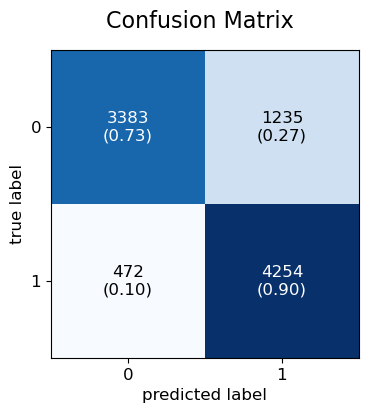

FP rate=FP/(FP+TN):  0.2674
Precision=TP/(TP+FP) :  0.7750
Recall=TP/(TP+FN) :  0.9001
AUC-PR:  0.7481
f1-score:  0.8329
roc_auc:  0.8163
Accuracy:  0.8173


In [190]:
performance_result(ytest,ada.predict(xtest))

In [193]:


gbc=wrapper(GradientBoostingClassifier()).fit(xtrain,ytrain)

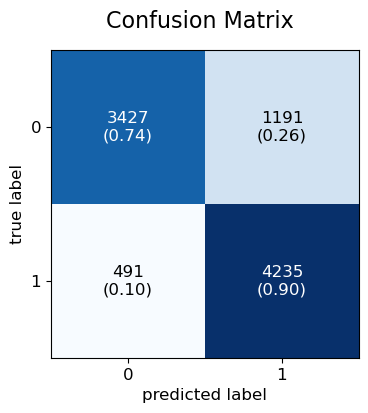

FP rate=FP/(FP+TN):  0.2579
Precision=TP/(TP+FP) :  0.7805
Recall=TP/(TP+FN) :  0.8961
AUC-PR:  0.7520
f1-score:  0.8343
roc_auc:  0.8191
Accuracy:  0.8200


In [194]:
performance_result(ytest,gbc.predict(xtest))

In [196]:
gsgbc=GridSearchCV(wrapper(GradientBoostingClassifier()).pipe,
             {'classifier__n_estimators': np.arange(50,250,25)},
                  verbose=5)
gsgbc.fit(xtrain,ytrain)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .......classifier__n_estimators=50;, score=0.820 total time=   2.8s
[CV 2/5] END .......classifier__n_estimators=50;, score=0.821 total time=   2.8s
[CV 3/5] END .......classifier__n_estimators=50;, score=0.821 total time=   2.8s
[CV 4/5] END .......classifier__n_estimators=50;, score=0.817 total time=   2.8s
[CV 5/5] END .......classifier__n_estimators=50;, score=0.820 total time=   2.8s
[CV 1/5] END .......classifier__n_estimators=75;, score=0.823 total time=   4.2s
[CV 2/5] END .......classifier__n_estimators=75;, score=0.822 total time=   4.2s
[CV 3/5] END .......classifier__n_estimators=75;, score=0.822 total time=   4.2s
[CV 4/5] END .......classifier__n_estimators=75;, score=0.818 total time=   4.2s
[CV 5/5] END .......classifier__n_estimators=75;, score=0.822 total time=   4.2s
[CV 1/5] END ......classifier__n_estimators=100;, score=0.825 total time=   5.6s
[CV 2/5] END ......classifier__n_estimators=100;,

GridSearchCV(estimator=Pipeline(steps=[('col_transform',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['mager',
                                                                          'riorlive',
                                                                          'riordead',
                                                                          'riorterm',
                                                                          'revis',
                                                                          'cig_0',
                                                                          'cig_1',
                                                                          'cig_2',
                                                                          'cig_3',
                                                                          'mhtr',
                                                                          'bmi',
                                                                          'wgt_r',
                                                                          'wtgain',
                                                                          'apgar5',
                                                                          'dplural']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['dob_mm',
                                                                          'dob_wk',
                                                                          'bfacil3',
                                                                          'mbstate_rec',
                                                                          'mrace6',
                                                                          'dmar',
                                                                          'meduc',
                                                                          'frace6',
                                                                          'feduc',
                                                                          'recare5',
                                                                          'dmeth_rec',
                                                                          'ay_rec',
                                                                          'sex'])])),
                                       ('classifier',
                                        GradientBoostingClassifier())]),
             param_grid={'classifier__n_estimators': array([ 50,  75, 100, 125, 150, 175, 200, 225])},
             verbose=5)

In [197]:
gsgbc.best_estimator_.named_steps['classifier']

GradientBoostingClassifier(n_estimators=125)

In [198]:
gbc_srched=wrapper(GradientBoostingClassifier(n_estimators=125)).fit(xtrain,ytrain)

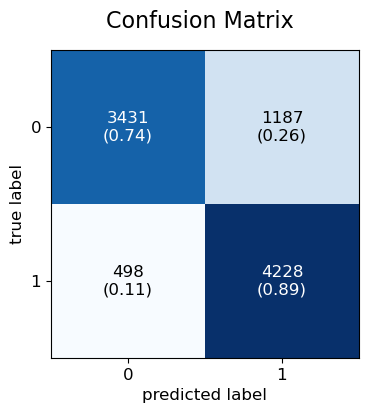

FP rate=FP/(FP+TN):  0.2570
Precision=TP/(TP+FP) :  0.7808
Recall=TP/(TP+FN) :  0.8946
AUC-PR:  0.7518
f1-score:  0.8338
roc_auc:  0.8188
Accuracy:  0.8197


In [199]:
performance_result(ytest,gbc_srched.predict(xtest))

### This Concludes the exploration Classifiers.